### Agentic RAG

Here is the workflow for current implementation

- Use two vector db's 
    - first db will have LangGraph related blogs
    - second db will have LangChain related blogs
- An Agent (Agent 1) will decide based on the user query to choose first db or second db
- Once the related documents are fetched, we check if the documents have correct information
    - If the information is selected document context is not appropriate
    - Rewrite (Agent 2) the query and send the updated query back to the agent
- If the info is correct - pass it as contect to the Generator (Agent 3) and finally output the response
- If an unrelated query is asked agent (Agent 1) will directly reject and appropriate answer will be sent as output


In [1]:
from langchain.chat_models import init_chat_model
from langchain.embeddings import init_embeddings

from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage, AnyMessage
from langchain_core.output_parsers import StrOutputParser

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS

from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langgraph.prebuilt import ToolNode, tools_condition

from langsmith import Client

from typing import Annotated, TypedDict, Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv

import os

load_dotenv()

/Users/srinivas/Documents/Others/My_projects/Python/DSAIML/agenticai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


True

### Model and Embedding initialization

In [2]:
# set the project name for tracing
os.environ["LANGCHAIN_PROJECT"] = "Agentic RAG"

In [3]:
model = init_chat_model(
    model="qwen/qwen3-32b",  # or any other Groq model
    model_provider="groq",
    temperature=0.7,
)

embeddings = init_embeddings("openai:text-embedding-3-small")

### Load, extract and flatten documents from Web

In [4]:
#  Load and extract docs from LangGraph docs

urls_lg = [
    "https://docs.langchain.com/oss/python/langgraph/quickstart",
    "https://docs.langchain.com/oss/python/langgraph/workflows-agents",
    "https://docs.langchain.com/oss/python/langgraph/use-graph-api#map-reduce-and-the-send-api"
]

# load the docs from the urls 
docs_lg = [WebBaseLoader(url).load() for url in urls_lg]
docs_lg

# extract the inner list from docs and flatten it 
flat_doc_list_lg = [doc for sublist in docs_lg for doc in sublist]
flat_doc_list_lg

[Document(metadata={'source': 'https://docs.langchain.com/oss/python/langgraph/quickstart', 'title': 'Quickstart - Docs by LangChain', 'language': 'en'}, page_content='Quickstart - Docs by LangChainSkip to main content🚀 Share how you\'re building agents for a chance to win LangChain swag!Docs by LangChain home pageLangChain + LangGraphSearch...⌘KAsk AIGitHubTry LangSmithTry LangSmithSearch...NavigationGet startedQuickstartLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonOverviewGet startedInstallQuickstartLocal serverThinking in LangGraphWorkflows + agentsCapabilitiesPersistenceDurable executionStreamingInterruptsTime travelMemorySubgraphsProductionApplication structureTestLangSmith StudioAgent Chat UILangSmith DeploymentLangSmith ObservabilityLangGraph APIsGraph APIFunctional APIRuntimeGet startedQuickstartCopy pageCopy pageThis quickstart demonstrates how to build a calculator agent using the LangGraph Graph API or the Functional API.\n\nUse the Graph API if you

In [5]:
#  Load and extract docs from LangGraph docs

urls_lc = [
    "https://docs.langchain.com/oss/python/langchain/overview",
    "https://docs.langchain.com/oss/python/langchain/agents",
    "https://docs.langchain.com/oss/python/langchain/guardrails"
]

# load the docs from the urls 
docs_lc = [WebBaseLoader(url).load() for url in urls_lc]
docs_lc

# extract the inner list from docs and flatten it 
flat_docs_list_lc = [doc for sublist in docs_lc for doc in sublist]
flat_docs_list_lc

[Document(metadata={'source': 'https://docs.langchain.com/oss/python/langchain/overview', 'title': 'LangChain overview - Docs by LangChain', 'language': 'en'}, page_content='LangChain overview - Docs by LangChainSkip to main content🚀 Share how you\'re building agents for a chance to win LangChain swag!Docs by LangChain home pageLangChain + LangGraphSearch...⌘KAsk AIGitHubTry LangSmithTry LangSmithSearch...NavigationLangChain overviewLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonOverviewGet startedInstallQuickstartPhilosophyCore componentsAgentsModelsMessagesToolsShort-term memoryStreamingStructured outputMiddlewareOverviewBuilt-in middlewareCustom middlewareAdvanced usageGuardrailsRuntimeContext engineeringModel Context Protocol (MCP)Human-in-the-loopMulti-agentRetrievalLong-term memoryAgent developmentLangSmith StudioTestAgent Chat UIDeploy with LangSmithDeploymentObservabilityOn this page Create an agent Core benefitsLangChain overviewCopy pageCopy pageLangCh

### Text Splitter, Document Store (Vector Store) and Retriever (Setup)

In [6]:
# Set up text splitter - recursive character based with chunk size of 1000 and chunk overlap of 100
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

In [7]:
doc_chunks_lg = text_splitter.split_documents(flat_doc_list_lg)
doc_chunks_lg

vectorstore_faiss = FAISS.from_documents(doc_chunks_lg, embeddings)
retriever_lg = vectorstore_faiss.as_retriever()

print(retriever_lg.invoke("How to build agents?"))

[Document(id='e86ebfc7-f5a1-4817-83f6-0c910d430d1f', metadata={'source': 'https://docs.langchain.com/oss/python/langgraph/workflows-agents', 'title': 'Workflows and agents - Docs by LangChain', 'language': 'en'}, page_content='# Compile the agent\nagent = agent_builder.compile()\n\n# Show the agent\ndisplay(Image(agent.get_graph(xray=True).draw_mermaid_png()))\n\n# Invoke\nmessages = [HumanMessage(content="Add 3 and 4.")]\nmessages = agent.invoke({"messages": messages})\nfor m in messages["messages"]:\n    m.pretty_print()\n\n\nEdit the source of this page on GitHub.\nConnect these docs programmatically to Claude, VSCode, and more via MCP for real-time answers.Was this page helpful?YesNoThinking in LangGraphPreviousPersistenceNext⌘IDocs by LangChain home pagegithubxlinkedinyoutubeResourcesForumChangelogLangChain AcademyTrust CenterCompanyAboutCareersBloggithubxlinkedinyoutubePowered by Mintlify'), Document(id='c4c220f5-b8f2-4bc0-9e47-7cb92ab724e7', metadata={'source': 'https://docs.lan

In [8]:
doc_lc_chunks = text_splitter.split_documents(flat_docs_list_lc)
doc_lc_chunks

vectorstore_chroma = Chroma.from_documents(doc_lc_chunks, embeddings)
retriever_lc = vectorstore_chroma.as_retriever()

print(retriever_lc.invoke("How to build chains?"))

[Document(id='b9a17390-505d-43b4-9432-e5bb5d897eda', metadata={'source': 'https://docs.langchain.com/oss/python/langchain/overview', 'title': 'LangChain overview - Docs by LangChain', 'language': 'en'}, page_content='LangChain is the easiest way to start building agents and applications powered by LLMs. With under 10 lines of code, you can connect to OpenAI, Anthropic, Google, and more. LangChain provides a pre-built agent architecture and model integrations to help you get started quickly and seamlessly incorporate LLMs into your agents and applications.\nWe recommend you use LangChain if you want to quickly build agents and autonomous applications. Use LangGraph, our low-level agent orchestration framework and runtime, when you have more advanced needs that require a combination of deterministic and agentic workflows, heavy customization, and carefully controlled latency.\nLangChain agents are built on top of LangGraph in order to provide durable execution, streaming, human-in-the-lo

### Setup Retriever as a tool

In [9]:
@tool
def retriever_lg_vector_db_blog(query: str) -> str:
    """Search and extract information about LangGraph"""
    docs = retriever_lg.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])

@tool
def retriever_lc_vector_db_blog(query: str) -> str:
    """Search and extract information about LangChain"""
    docs = retriever_lc.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])

retriever_langgraph_tool = retriever_lg_vector_db_blog
retriever_langchain_tool = retriever_lc_vector_db_blog

tools = [retriever_langgraph_tool, retriever_langchain_tool]

### Status Till Now:

- Extracted documents from web about LangGraph
- It has information about LangGraph Implementation
- Used FAISS vectorstore to save the document and chunking them
- Created vectorstore as retriever
- Created retriever tool


### Combine tools

In [10]:
tools = [retriever_langgraph_tool, retriever_langchain_tool]

### Bind the Model with tools

In [11]:
model_with_tools = model.bind_tools(tools=tools)

### Build Graph

Step 1: Create an Agent that will use model with tools to get relavent documents based on query

In [12]:
class AgentState(TypedDict):
    # add_messages is a reducer function, that defines how to add messages to the list
    # by default state would replace the entry, but with add_messages it would append to the list
    messages: Annotated[list[AnyMessage], add_messages]

In [13]:
def agent_node(state: AgentState) -> AgentState:
    """ 
    Invokes the agent model to generate a response based on current state. Given the
    question, it will decide to call the retriever tool or end the call"""

    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

### Next Steps

In [14]:
# Add Structured Schema for Grading
class GradeSchema(BaseModel):
    """Binary score for relevance check"""
    binary_score: Literal["yes", "no"] = Field(description="Binary score for relevance check, with yes or no")

# Now update the Model with this schema so that we can get only binary score
model_with_schema = model.with_structured_output(GradeSchema)

In [15]:
def grade_docs_node(state: AgentState) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved docs are good enough to answer the question. 
    If yes, generate the answer.
    If not, rewrite the question.
    """

    template = """
    You are an assistant that will assess the relevance of retrieved docs to answer a question.

    Here is the retrieved docs: \n{retrieved_docs}\n

    Question: \n{question}\n

    If the retrieved docs are relevant keyword(s) and symantic meaning related to the question asked, 
    then grade with 'yes'. Otherwise, answer with 'no'.
    """

    prompt = ChatPromptTemplate.from_template(template)

    chain = prompt | model_with_schema

    messages = state["messages"]

    question = messages[0].content
    retrieved_docs = messages[-1].content

    response = chain.invoke({"retrieved_docs": retrieved_docs, "question": question})
    score = response.binary_score

    if score == "yes":
        print(f"Docs are good enough to answer the question, score: {score}, verdict: generate")
        return "generate"
    else:
        print(f"Docs are not good enough to answer the question, score: {score}, verdict: rewrite")
        return "rewrite"

In [16]:
def generate_answer_node(state: AgentState) -> AgentState:

    client = Client()
    prompt = client.pull_prompt("rlm/rag-prompt")

    messages = state["messages"]

    question = messages[0].content
    retrieved_docs = messages[-1].content

    parser = StrOutputParser()

    rag_chain = prompt | model | parser

    response = rag_chain.invoke({"context": retrieved_docs, "question": question})

    return {"messages": [response]}

In [17]:
def rewrite_question_node(state: AgentState) -> AgentState:
    messages = state["messages"]

    question = messages[0].content

    messages = [
        SystemMessage(content=f"You are an assistant that will rewrite the question"),
        HumanMessage(content=f"""Look at the question below and rewrite it, 
                     to be more specific and clear based symantic intent \n\n 
                     Question: {question} \n\n
                     Rewritten Question: """),
    ]

    response = model.invoke(messages)

    return {"messages": [response]}

In [18]:
retriever_node = ToolNode(tools)

### Create a State Graph

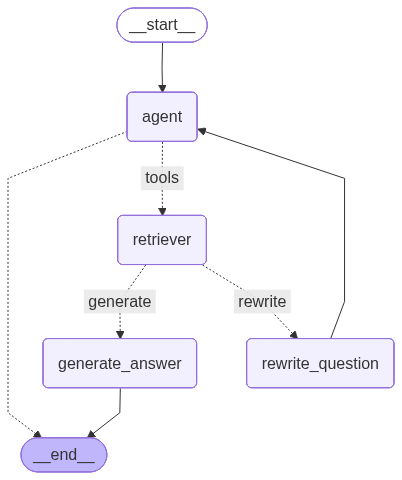

In [19]:
graph = StateGraph(AgentState)

graph.add_node("agent", agent_node)
graph.add_node("retriever", retriever_node)
graph.add_node("generate_answer", generate_answer_node)
graph.add_node("rewrite_question", rewrite_question_node)

graph.add_edge(START, "agent")
graph.add_conditional_edges("agent", tools_condition, {"tools": "retriever", END: END})
graph.add_conditional_edges("retriever", grade_docs_node, {"generate": "generate_answer", "rewrite": "rewrite_question"})
graph.add_edge("rewrite_question", "agent")
graph.add_edge("generate_answer", END)

workflow = graph.compile()
workflow

In [23]:
initial_state = {"messages": [HumanMessage(content="What is LangChain?")]}

output = workflow.invoke(initial_state)

for message in output["messages"]:
    message.pretty_print()

Docs are good enough to answer the question, score: yes, verdict: generate
================================ Human Message =================================

What is LangChain?
================================== Ai Message ==================================
Tool Calls:
  retriever_lc_vector_db_blog (7fryv4hkc)
 Call ID: 7fryv4hkc
  Args:
    query: What is LangChain?
================================= Tool Message =================================
Name: retriever_lc_vector_db_blog

LangChain is the easiest way to start building agents and applications powered by LLMs. With under 10 lines of code, you can connect to OpenAI, Anthropic, Google, and more. LangChain provides a pre-built agent architecture and model integrations to help you get started quickly and seamlessly incorporate LLMs into your agents and applications.
We recommend you use LangChain if you want to quickly build agents and autonomous applications. Use LangGraph, our low-level agent orchestration framework and runtime, wh

In [24]:
initial_state = {"messages": [HumanMessage(content="What is Machine Learning?")]}

output = workflow.invoke(initial_state)

for message in output["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is Machine Learning?
================================== Ai Message ==================================

The user is asking about Machine Learning in general, but the available tools are designed to search for information specifically related to LangGraph and LangChain. Since there is no function to retrieve general Machine Learning definitions, I cannot use the provided tools to answer this query. 

However, here's a brief explanation: **Machine Learning** is a subset of artificial intelligence that involves training algorithms to learn patterns from data, enabling them to make decisions or predictions without being explicitly programmed for each task. It includes techniques like supervised learning, unsupervised learning, and reinforcement learning.
